In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

# Загрузка и подготовка данных
data = pd.read_csv('BTC1d.csv', delimiter=',', parse_dates=True)
data = data.rename(columns={'Close': 'Value'})
data = data.rename(columns={'Open time': 'Date'})
data = data.drop(['Open', 'Low', 'High', 'Volume',
                  'Close time', 'Quote asset volume', 'Number of trades',
                  'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], axis=1)
# 1d
data['Date'] = data['Date'].str.split(' ').str[0]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

data.set_index('Date', inplace=True)

data_filtered = data[(data.index >= '2021-01-01') & (data.index < '2025-01-01')]
print(data_filtered)

                Value
Date                 
2021-01-01   29331.69
2021-01-02   32178.33
2021-01-03   33000.05
2021-01-04   31988.71
2021-01-05   33949.53
...               ...
2024-12-06   99740.84
2024-12-07   99831.99
2024-12-08  101109.59
2024-12-09   97276.47
2024-12-10   98015.36

[1440 rows x 1 columns]


In [ ]:
# Определение функции для создания признаков и целевых значений на основе временного ряда
def create_features(data, look_back=60):
    # Инициализация пустых списков для входных данных (X) и целевых значений (y)
    X, y = [], []

    # Цикл для скользящего окна по данным
    for i in range(len(data) - look_back):
        # Добавление окна данных размером `look_back` в X (признаки)
        X.append(data[i:(i + look_back), 0])

        # Добавление значения, следующего за окном, в y (целевые значения)
        y.append(data[i + look_back, 0])

    # Преобразование списков X и y в numpy-массивы для дальнейшей обработки
    return np.array(X), np.array(y)

In [ ]:
# Создание объекта MinMaxScaler для масштабирования данных в диапазон [0, 1]
scaler = MinMaxScaler()

# Применение масштабирования к данным:
# - .values извлекает значения DataFrame в виде массива
# - .reshape(-1, 1) преобразует массив в двумерный вид, необходимый для работы MinMaxScaler
data_filtered_scaled = scaler.fit_transform(data_filtered.values.reshape(-1, 1))

# Вывод формы (размерности) масштабированных данных для проверки
print(data_filtered_scaled.shape)

(1440, 1)


In [ ]:
# Создание признаков (X) и целевых значений (y) с использованием функции create_features
# Для масштабированных данных, подготовленных ранее
X, y = create_features(data_filtered_scaled)

# Вывод формы массивов X (признаки) и y (целевые значения) для проверки
print(X.shape, y.shape)

# Разделение данных на тренировочный (X_train, y_train) и тестовый (X_test, y_test) наборы
# Параметр test_size=0.2 означает, что 20% данных будет использовано для тестирования
# shuffle=False отключает перемешивание данных, что важно для временных рядов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

(1380, 60) (1380,)


In [ ]:
# Создание массива направления изменения целевого значения y_train:
# Если текущее значение больше предыдущего, результат будет True (1), иначе False (0).
# np.roll(y_train, 1) сдвигает массив на один элемент вправо.
# [1:] используется для исключения первого элемента, так как он не имеет предыдущего значения.
y_direction = (y_train > np.roll(y_train, 1))[1:].astype(int)

# Исключение первого элемента из X_train, чтобы размеры X_train_lr и y_direction совпадали.
X_train_lr = X_train[1:]

# Создание классификатора логистической регрессии с фиксированным random_state для воспроизводимости.
lr_classifier = LogisticRegression(random_state=42)

# Определение параметров для подбора гиперпараметров логистической регрессии:
# - tol: допустимая ошибка (точность).
# - solver: различные алгоритмы для оптимизации логистической регрессии.
lr_params = {
    "tol": [0.00001, 0.0001, 0.001],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# Создание объекта GridSearchCV для поиска наилучших гиперпараметров:
# - lr_classifier: модель логистической регрессии.
# - lr_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
lr_grid = GridSearchCV(lr_classifier, lr_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train_lr и y_direction.
lr_grid.fit(X_train_lr, y_direction)

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_lr_params = lr_grid.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
print(best_lr_params)

{'solver': 'lbfgs', 'tol': 0.0001}


In [ ]:
lr_model = LogisticRegression(**best_lr_params,random_state=42)
lr_model.fit(X_train_lr, y_direction)

LogisticRegression(random_state=42)

In [ ]:
# Создание объекта модели машины опорных векторов (Support Vector Regression, SVR)
svm_classifier = SVR()

# Определение параметров для подбора гиперпараметров SVR:
# - kernel: тип ядра для регрессии (линейное, полиномиальное, радиальная функция и сигмоидальное).
# - degree: степень полинома (используется только для ядра 'poly').
# - gamma: коэффициент ядра ('scale' - автоматическая настройка, 'auto' - на основе количества признаков).
# - tol: допустимая ошибка (точность).
svm_params = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [1, 3, 5, 7],
    "gamma": ['scale', 'auto'],
    "tol": [0.00001, 0.0001, 0.001]
}

# Создание объекта GridSearchCV для подбора гиперпараметров модели SVR:
# - svm_classifier: модель SVR.
# - svm_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
svm_grid = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train и y_train.ravel():
# - .ravel() преобразует массив y_train в одномерный вид, необходимый для SVR.
svm_grid.fit(X_train, y_train.ravel())

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_svm_params = svm_grid.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
print(best_svm_params)

{'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.001}


In [ ]:
svm_model = SVR(**best_svm_params)
svm_model.fit(X_train, y_train.ravel())


SVR(degree=1, kernel='linear')

In [ ]:
# Создание объекта модели случайного леса для регрессии (RandomForestRegressor)
rf_classifier = RandomForestRegressor()

# Определение параметров для подбора гиперпараметров случайного леса:
# - n_estimators: количество деревьев в лесу (10, 100, 1000).
# - criterion: критерий для оценки качества разделений (среднеквадратичная ошибка, абсолютная ошибка, фридмановская ошибка, пуассон).
# - max_depth: максимальная глубина дерева (1, 10, 100).
rf_params = {
    "n_estimators": [10, 100, 1000],
    "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "max_depth": [1, 10, 100]
}

# Создание объекта GridSearchCV для подбора гиперпараметров модели случайного леса:
# - rf_classifier: модель случайного леса.
# - rf_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
rf_grid = GridSearchCV(rf_classifier, rf_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train и y_train.ravel():
# - .ravel() преобразует массив y_train в одномерный вид, необходимый для RandomForestRegressor.
rf_grid.fit(X_train, y_train.ravel())

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_rf_params = rf_grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
print(best_rf_params)

{'criterion': 'poisson', 'max_depth': 100, 'n_estimators': 1000}


In [ ]:
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train.ravel())

RandomForestRegressor(criterion='poisson', max_depth=100, n_estimators=1000,
                      random_state=42)

In [ ]:
# Создание объекта модели XGBoost для регрессии (XGBRegressor)
xgb_classifier = XGBRegressor()

# Определение параметров для подбора гиперпараметров модели XGBoost:
# - n_estimators: количество деревьев в модели (10, 100, 1000).
# - learning_rate: коэффициент обучения (1, 0.1, 0.01, 0.001).
# - max_depth: максимальная глубина дерева (1, 10, 100).
xgb_params = {
    "n_estimators": [10, 100, 1000],
    "learning_rate": [1, 0.1, 0.01, 0.001],
    "max_depth": [1, 10, 100]
}

# Создание объекта GridSearchCV для подбора гиперпараметров модели XGBoost:
# - xgb_classifier: модель XGBoost.
# - xgb_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
xgb_grid = GridSearchCV(xgb_classifier, xgb_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train и y_train.ravel():
# - .ravel() преобразует массив y_train в одномерный вид, необходимый для XGBoost.
xgb_grid.fit(X_train, y_train.ravel())

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_xgb_params = xgb_grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
print(best_xgb_params)

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}


In [ ]:
xgb_model = XGBRegressor(**best_xgb_params, random_state=42)
xgb_model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    if model_name == 'Logistic Regression':
        # Для логистической регрессии прогнозируем направление движения
        y_pred_direction = model.predict(X_test)
        y_pred = np.where(y_pred_direction == 1, y_test + 0.01, y_test - 0.01)
    else:
        y_pred = model.predict(X_test).reshape(-1, 1)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    return y_pred

In [ ]:
lr_pred = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')
svm_pred = evaluate_model(svm_model, X_test, y_test, 'SVM')
rf_pred = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
xgb_pred = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')

Logistic Regression - MAE: 0.0100, RMSE: 0.0100
SVM - MAE: 0.0409, RMSE: 0.0528
Random Forest - MAE: 0.0758, RMSE: 0.1317
XGBoost - MAE: 0.0618, RMSE: 0.1156


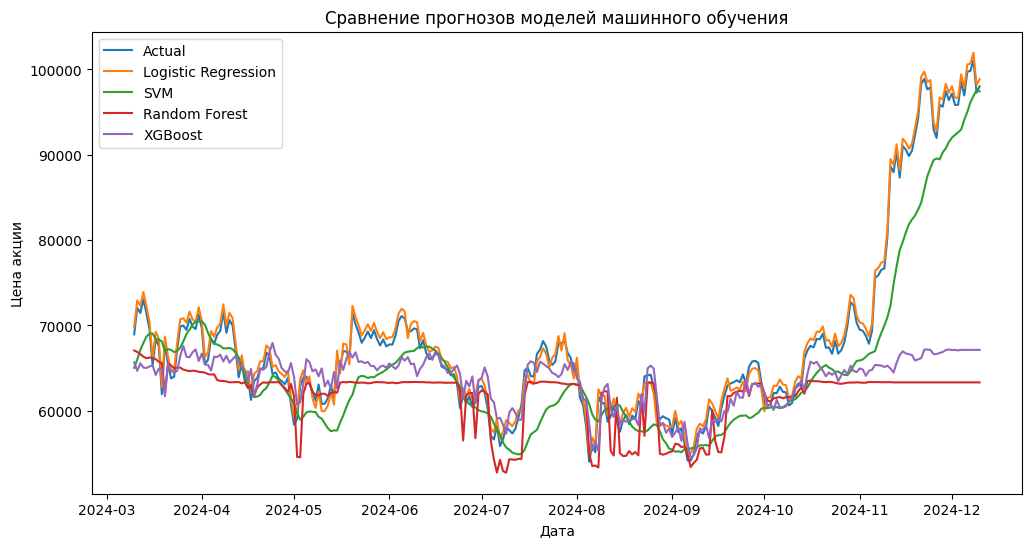

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(lr_pred.reshape(-1, 1)), label='Logistic Regression')
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(svm_pred.reshape(-1, 1)), label='SVM')
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(rf_pred.reshape(-1, 1)), label='Random Forest')
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(xgb_pred.reshape(-1, 1)), label='XGBoost')
plt.title('Сравнение прогнозов моделей машинного обучения')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.show()

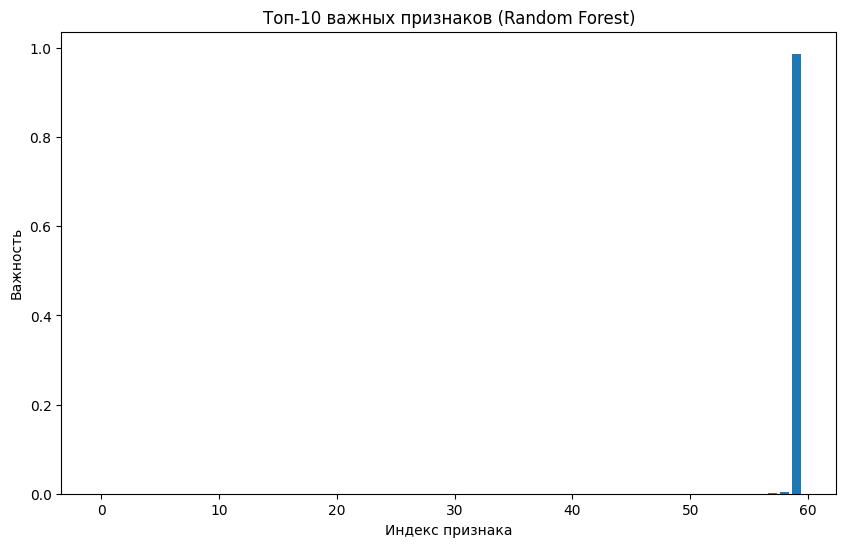

In [ ]:
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Топ-10 важных признаков (Random Forest)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()